In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import glob


# Get all JSON files in the directory
file_paths = glob.glob(r'raw_data_rotterdam/*.json')

# Read and concatenate all JSON files
df_list = [pd.read_json(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

# Normalize the nested JSON data
df_normalized = json_normalize(df['data'])

In [3]:
# list of columns to keep
keep = ['navigation.time', 
        'navigation.location.long', 'navigation.location.lat', 
        'navigation.destination.name', 
        'navigation.destination.eta', 'navigation.status', 
        'device.mmsi', 
        'vessel.type', 
        'vessel.imo', 'vessel.name']

# filter the columns
df_keep = df_normalized[keep]

In [4]:
# convert the time to datetime
df_keep = df_keep.copy()
df_keep['navigation.time'] = pd.to_datetime(df_keep['navigation.time'])
df_keep['day'] = df_keep['navigation.time'].dt.day
df_keep['hour'] = df_keep['navigation.time'].dt.hour
df_keep['minute'] = df_keep['navigation.time'].dt.minute


In [5]:
# remove vessel.name with less than 10 occurrences
df_keep = df_keep.groupby('vessel.name').filter(lambda x: len(x) > 10)

# for each vessel.name, create a new dataframe
df_vessels = {}
for vessel in df_keep['vessel.name'].unique():
    df_vessels[vessel] = df_keep[df_keep['vessel.name'] == vessel]

# drop MAYVIEW MAERSK from the dictionary
df_vessels.pop('MAYVIEW MAERSK')

# show the keys of the dictionary with their size
for key in df_vessels.keys():
    print(key, df_vessels[key].shape)

JAN LEEGHWATER (7009, 13)
AARBURG (6339, 13)
ORION (1982, 13)
LEVANTE (8202, 13)
JORDY-M (8906, 13)
HELENA (6414, 13)
CHARLOIS (8721, 13)
TRUDIE (8909, 13)
CAAN (7008, 13)
ROMEE (7198, 13)
WESTERSCHELDE (7469, 13)
SUNMI (1128, 13)
MARIBO MAERSK (691, 13)


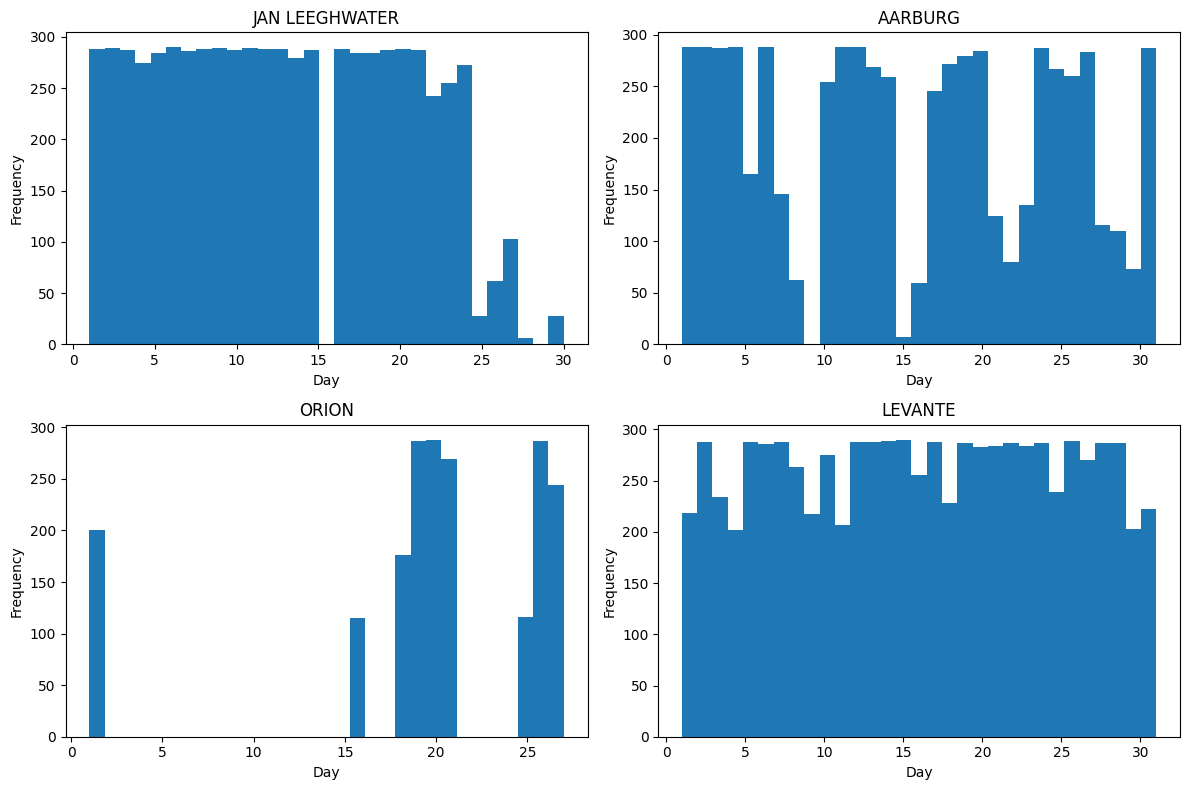

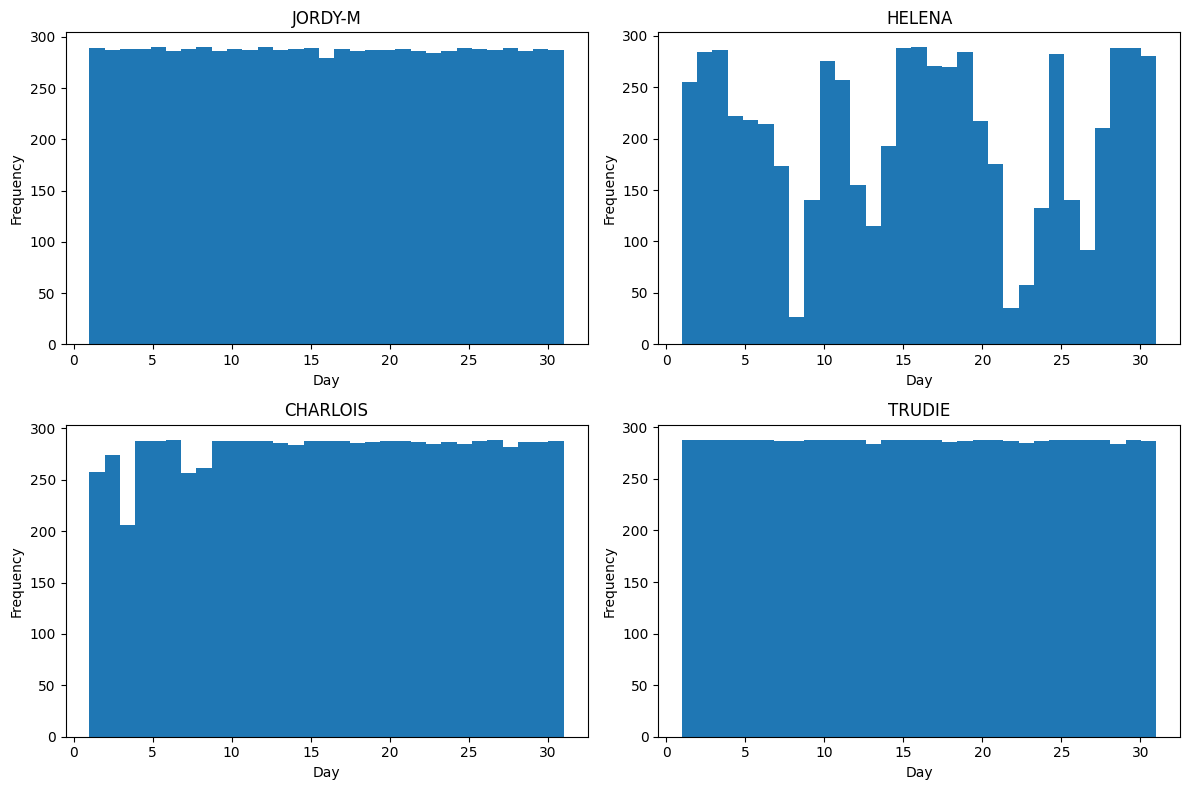

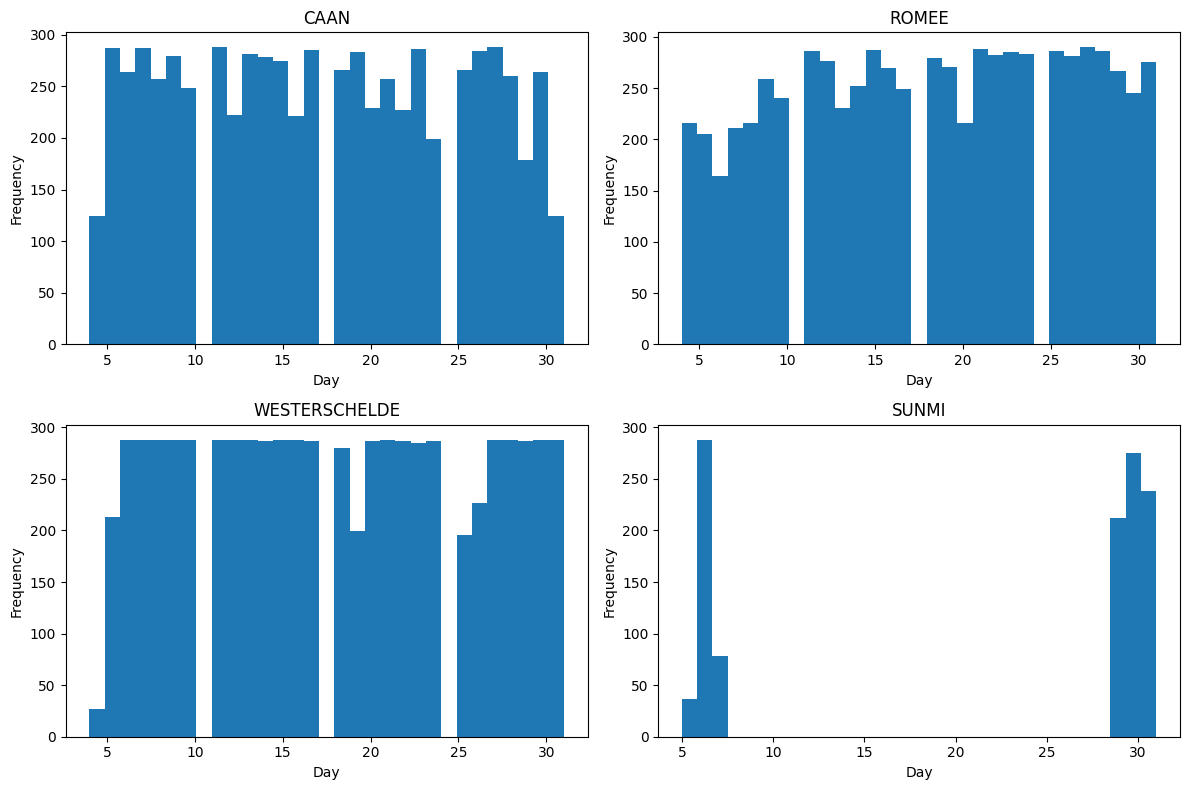

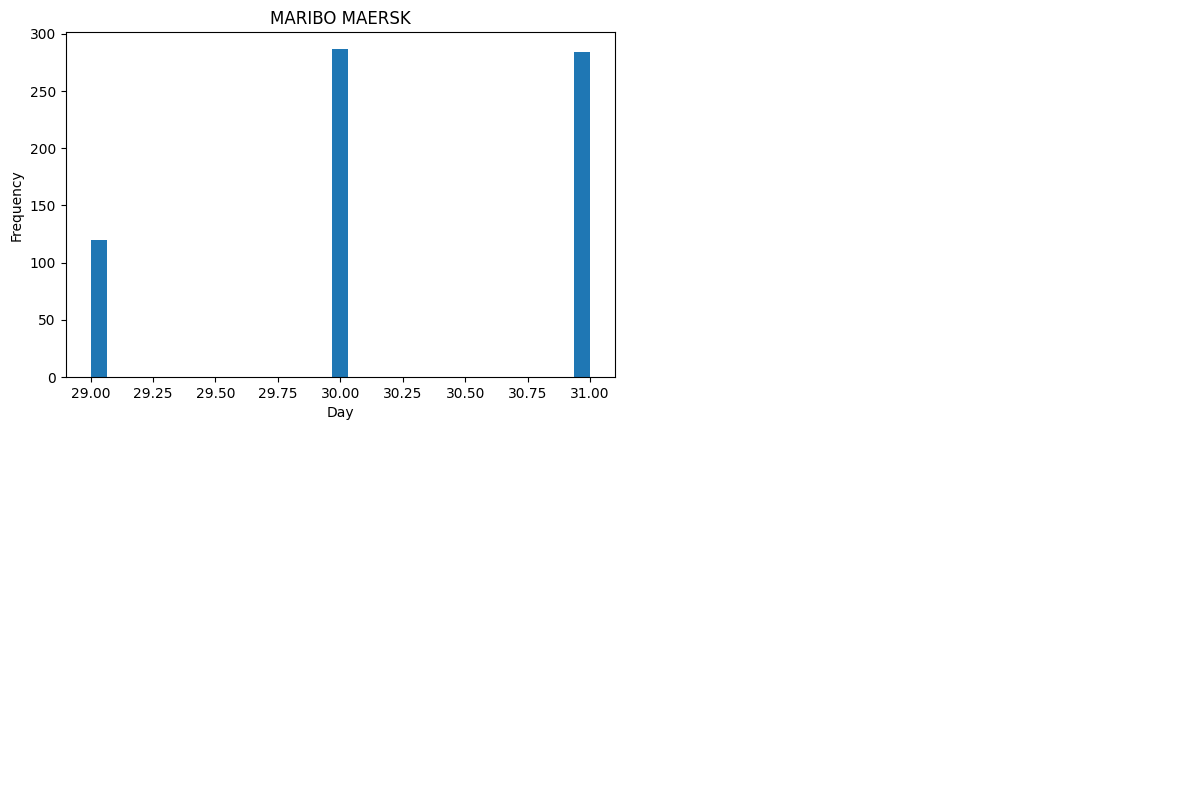

In [6]:
# Divide vessels into chunks of 4 and plot each chunk in a 2x2 grid
vessel_names = list(df_vessels.keys())
num_vessels = len(vessel_names)
vessels_per_plot = 4

for start in range(0, num_vessels, vessels_per_plot):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i, key in enumerate(vessel_names[start:start + vessels_per_plot]):
        axes[i].hist(df_vessels[key]['day'], bins=31)
        axes[i].set_title(key)
        axes[i].set_xlabel('Day')
        axes[i].set_ylabel('Frequency')

    # Hide unused subplots
    for j in range(len(vessel_names[start:start + vessels_per_plot]), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [7]:
from ipywidgets import widgets
from mpl_toolkits.basemap import Basemap

# Create a dropdown widget for selecting a vessel
vessel_dropdown = widgets.Dropdown(
    options=[(name, name) for name in df_vessels.keys()],
    value=list(df_vessels.keys())[0],
    description='Vessel:',
)

# Function to update the map based on the selected vessel
def update_vessel_map(vessel_name):
    fig, ax = plt.subplots(figsize=(16, 16))  # Increased the figure size
    m = Basemap(projection='merc', llcrnrlat=49.0, urcrnrlat=54.0,
                llcrnrlon=3.0, urcrnrlon=9.5, resolution='i', ax=ax)

    # Draw coastlines, countries, and map boundaries
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')

    # Plot the datapoints for the selected vessel
    vessel_data = df_vessels[vessel_name]
    x, y = m(vessel_data['navigation.location.long'].values,
             vessel_data['navigation.location.lat'].values)
    ax.scatter(x, y, label=vessel_name, color='red')

    ax.legend()
    plt.show()

# Link the dropdown to the update_vessel_map function
interactive_vessel_plot = widgets.interactive(update_vessel_map, vessel_name=vessel_dropdown)

# Display the dropdown and the interactive plot
display(vessel_dropdown, interactive_vessel_plot)

Dropdown(description='Vessel:', options=(('JAN LEEGHWATER', 'JAN LEEGHWATER'), ('AARBURG', 'AARBURG'), ('ORION…

interactive(children=(Dropdown(description='Vessel:', options=(('JAN LEEGHWATER', 'JAN LEEGHWATER'), ('AARBURG…

In [8]:
# ---- Create resulting dataframes ----

# A: strict dataframe for rotterdam port area = vessels which have data for this area
vessels_slim_rotterdam = ['AARBURG', 'LEVANTE', 'JORDY-M', 'CHARLOIS', 'TRUDIE', 'CAAN', 'ROMEE', 'WESTERSCHELDE']
df_slim_rotterdam = pd.concat([df_vessels[vessel] for vessel in vessels_slim_rotterdam])

# only coordinates in this area 
df_slim_rotterdam = df_slim_rotterdam[(df_slim_rotterdam['navigation.location.lat'] > 51.8) & 
                                      (df_slim_rotterdam['navigation.location.lat'] < 52.0) & 
                                      (df_slim_rotterdam['navigation.location.long'] > 4.0) & 
                                      (df_slim_rotterdam['navigation.location.long'] < 4.6)]

# B: strict dataframe for rotterdam area with additionally ORION, SUNMI, MARIBO MAERSK
vessels_wide_rotterdam = ['AARBURG', 'LEVANTE', 'JORDY-M', 'CHARLOIS', 'TRUDIE', 'CAAN', 'ROMEE', 'WESTERSCHELDE', 'ORION', 'SUNMI', 'MARIBO MAERSK']
df_wide_rotterdam = pd.concat([df_vessels[vessel] for vessel in vessels_wide_rotterdam])

# only coordinates in this area
df_wide_rotterdam = df_wide_rotterdam[(df_wide_rotterdam['navigation.location.lat'] > 51.8) & 
                                      (df_wide_rotterdam['navigation.location.lat'] < 52.0) & 
                                      (df_wide_rotterdam['navigation.location.long'] > 4.0) & 
                                      (df_wide_rotterdam['navigation.location.long'] < 4.6)]


# C: dataframes with all moving vessels, only exclude points below frankfurt as they are disconnected from the rest
vessels_all = vessels_wide_rotterdam + ['HELENA']     # so all vessels except JAN LEEGHWATER
df_all = pd.concat([df_vessels[vessel] for vessel in vessels_all])

# remove datapoints below frankfurt
df_all = df_all[df_all['navigation.location.lat'] > 50.5]






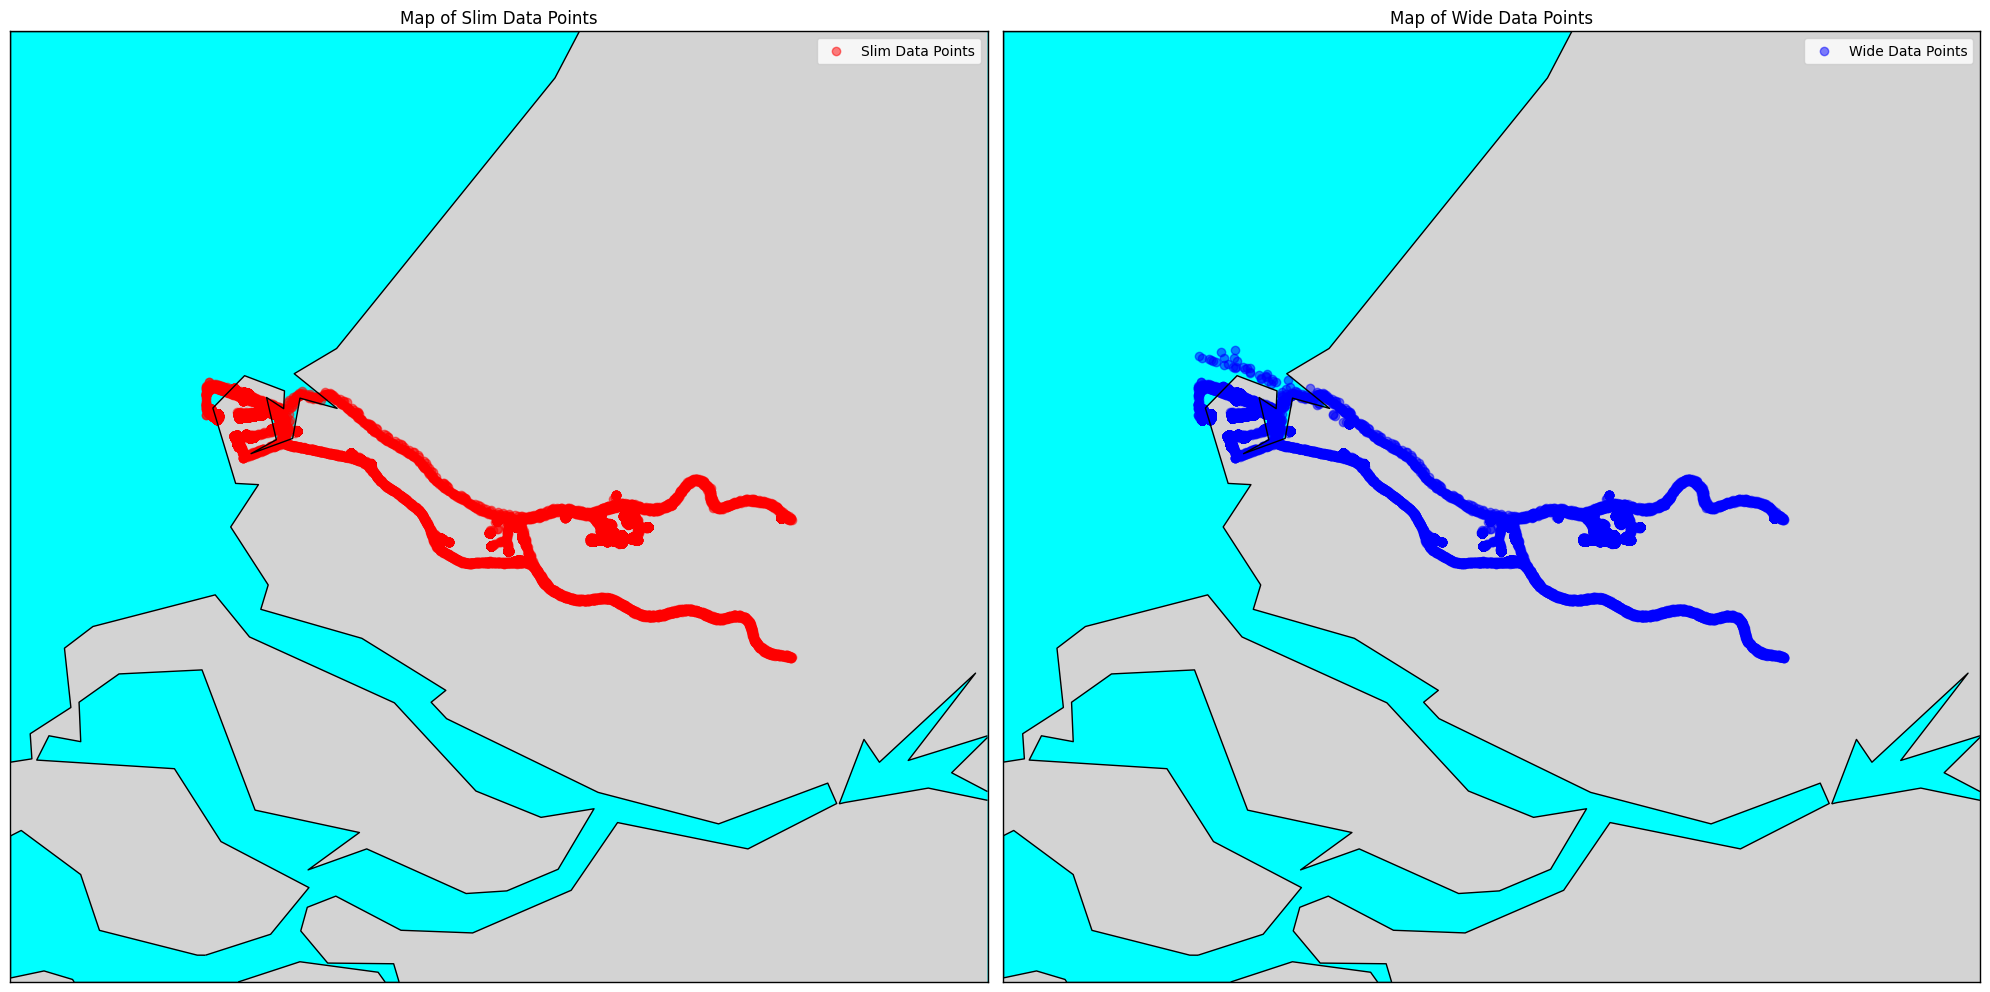

In [9]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# First subplot: Map with datapoints from df_slim_rotterdam
m1 = Basemap(projection='merc', llcrnrlat=51.6, urcrnrlat=52.2,
             llcrnrlon=3.8, urcrnrlon=4.8, resolution='i', ax=axes[0])

# Draw coastlines, countries, and map boundaries
m1.drawcoastlines()
m1.drawcountries()
m1.drawmapboundary(fill_color='aqua')
m1.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the datapoints from df_slim_rotterdam
x_slim, y_slim = m1(df_slim_rotterdam['navigation.location.long'].values,
                    df_slim_rotterdam['navigation.location.lat'].values)
axes[0].scatter(x_slim, y_slim, marker='o', color='red', alpha=0.5, label='Slim Data Points')

axes[0].legend()
axes[0].set_title('Map of Slim Data Points')

# Second subplot: Map with datapoints from df_wide_rotterdam
m2 = Basemap(projection='merc', llcrnrlat=51.6, urcrnrlat=52.2,
             llcrnrlon=3.8, urcrnrlon=4.8, resolution='i', ax=axes[1])

# Draw coastlines, countries, and map boundaries
m2.drawcoastlines()
m2.drawcountries()
m2.drawmapboundary(fill_color='aqua')
m2.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the datapoints from df_wide_rotterdam
x_wide, y_wide = m2(df_wide_rotterdam['navigation.location.long'].values,
                    df_wide_rotterdam['navigation.location.lat'].values)
axes[1].scatter(x_wide, y_wide, marker='o', color='blue', alpha=0.5, label='Wide Data Points')

axes[1].legend()
axes[1].set_title('Map of Wide Data Points')

plt.tight_layout()
plt.show()

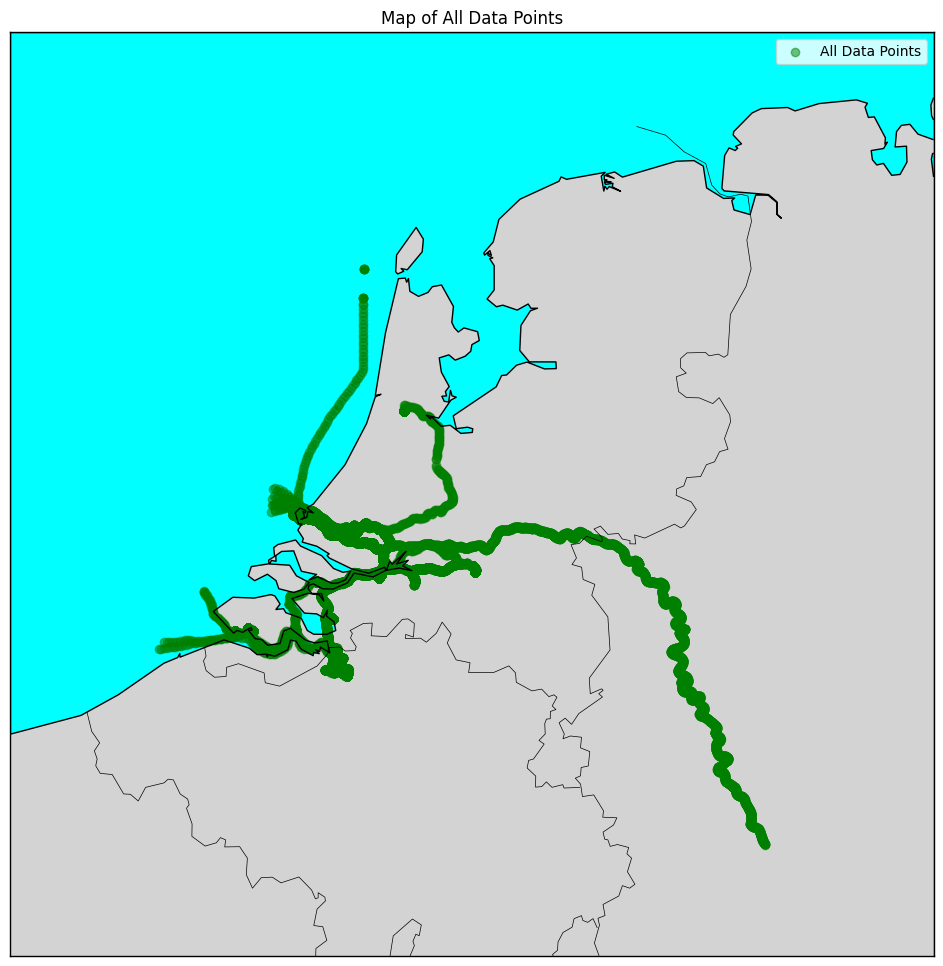

In [13]:
# Create a map to plot datapoints from df_all
fig, ax = plt.subplots(figsize=(12, 12))

# Initialize the Basemap
m3 = Basemap(projection='merc', llcrnrlat=50.0, urcrnrlat=54.0,
             llcrnrlon=2.0, urcrnrlon=8.5, resolution='i', ax=ax)

# Draw coastlines, countries, and map boundaries
m3.drawcoastlines()
m3.drawcountries()
m3.drawmapboundary(fill_color='aqua')
m3.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the datapoints from df_all
x_all, y_all = m3(df_all['navigation.location.long'].values,
                  df_all['navigation.location.lat'].values)
ax.scatter(x_all, y_all, marker='o', color='green', alpha=0.5, label='All Data Points')

ax.legend()
ax.set_title('Map of All Data Points')

plt.show()

In [14]:
# save df_wide and df_slim to json
df_wide_rotterdam.to_json('df_wide_rotterdam.json', orient='records')
df_slim_rotterdam.to_json('df_slim_rotterdam.json', orient='records')